# Creating a normalized database (3NF)

In [1]:
{
 "kernelspec": {
  "display_name": "Python 3",
  "language": "python",
  "name": "python3"
 },
 "language_info": {
  "codemirror_mode": {
   "name": "ipython",
   "version": 3
  },
  "file_extension": ".py",
  "mimetype": "text/x-python",
  "name": "python",
  "nbconvert_exporter": "python",
  "pygments_lexer": "ipython3",
  "version": "3.8.0"
 }
}

{'kernelspec': {'display_name': 'Python 3',
  'language': 'python',
  'name': 'python3'},
 'language_info': {'codemirror_mode': {'name': 'ipython', 'version': 3},
  'file_extension': '.py',
  'mimetype': 'text/x-python',
  'name': 'python',
  'nbconvert_exporter': 'python',
  'pygments_lexer': 'ipython3',
  'version': '3.8.0'}}

In [2]:
import pandas as pd
import numpy as np

df_csv = pd.read_csv('mobile_prices.csv')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import ydata_profiling

profile = ydata_profiling.ProfileReport(df_csv, title="Pandas Profiling Report")
# profile

In [4]:
import pandas as pd
import sqlite3
from pathlib import Path
from tqdm import tqdm  # For progress bar

csv_path = 'mobile_prices.csv'

def create_database(csv_path, db_path='mobile_phones.db'):
    # Load CSV data
    print(f"Loading data from {csv_path}...")
    df_csv = pd.read_csv(csv_path)
    print(f"Loaded {len(df_csv)} records from CSV")
    
    # Create SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Create tables
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS phones (
        phone_id INTEGER PRIMARY KEY AUTOINCREMENT,
        battery_power INTEGER NOT NULL,
        clock_speed DECIMAL(3,1) NOT NULL,
        m_dep DECIMAL(3,1) NOT NULL,
        mobile_wt INTEGER NOT NULL,
        n_cores INTEGER NOT NULL,
        ram INTEGER NOT NULL,
        talk_time INTEGER NOT NULL,
        price_range INTEGER NOT NULL,
        CONSTRAINT chk_price_range CHECK (price_range BETWEEN 0 AND 3)
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS screen_specs (
        screen_id INTEGER PRIMARY KEY AUTOINCREMENT,
        phone_id INTEGER NOT NULL,
        px_height INTEGER NOT NULL,
        px_width INTEGER NOT NULL,
        sc_h DECIMAL(4,1) NOT NULL,
        sc_w DECIMAL(4,1) NOT NULL,
        FOREIGN KEY (phone_id) REFERENCES phones(phone_id)
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS camera_specs (
        camera_id INTEGER PRIMARY KEY AUTOINCREMENT,
        phone_id INTEGER NOT NULL,
        fc INTEGER NOT NULL,
        pc INTEGER NOT NULL,
        FOREIGN KEY (phone_id) REFERENCES phones(phone_id)
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS phone_features (
        feature_id INTEGER PRIMARY KEY AUTOINCREMENT,
        phone_id INTEGER NOT NULL,
        blue BOOLEAN NOT NULL,
        dual_sim BOOLEAN NOT NULL,
        four_g BOOLEAN NOT NULL,
        three_g BOOLEAN NOT NULL,
        touch_screen BOOLEAN NOT NULL,
        wifi BOOLEAN NOT NULL,
        FOREIGN KEY (phone_id) REFERENCES phones(phone_id)
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS storage_specs (
        storage_id INTEGER PRIMARY KEY AUTOINCREMENT,
        phone_id INTEGER NOT NULL,
        int_memory INTEGER NOT NULL,
        FOREIGN KEY (phone_id) REFERENCES phones(phone_id)
    )
    ''')
    
    # Insert data into tables with progress bar
    print("\nInserting data into database...")
    for index in tqdm(range(len(df_csv)), desc="Processing records"):
        row = df_csv.iloc[index]
        
        # Insert into phones table
        cursor.execute('''
        INSERT INTO phones (
            battery_power, clock_speed, m_dep, mobile_wt, n_cores,
            ram, talk_time, price_range
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            row['battery_power'], row['clock_speed'], row['m_dep'],
            row['mobile_wt'], row['n_cores'], row['ram'],
            row['talk_time'], row['price_range']
        ))
        
        # Get the last inserted phone_id
        phone_id = cursor.lastrowid
        
        # Insert into screen_specs
        cursor.execute('''
        INSERT INTO screen_specs (
            phone_id, px_height, px_width, sc_h, sc_w
        ) VALUES (?, ?, ?, ?, ?)
        ''', (phone_id, row['px_height'], row['px_width'], row['sc_h'], row['sc_w']))
        
        # Insert into camera_specs
        cursor.execute('''
        INSERT INTO camera_specs (
            phone_id, fc, pc
        ) VALUES (?, ?, ?)
        ''', (phone_id, row['fc'], row['pc']))
        
        # Insert into phone_features
        cursor.execute('''
        INSERT INTO phone_features (
            phone_id, blue, dual_sim, four_g, three_g, touch_screen, wifi
        ) VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (
            phone_id, row['blue'], row['dual_sim'], row['four_g'],
            row['three_g'], row['touch_screen'], row['wifi']
        ))
        
        # Insert into storage_specs
        cursor.execute('''
        INSERT INTO storage_specs (
            phone_id, int_memory
        ) VALUES (?, ?)
        ''', (phone_id, row['int_memory']))
    
    # Commit changes and close connection
    conn.commit()
    conn.close()
    
    print(f"\nDatabase created successfully at {db_path}")

def verify_database(db_path='mobile_phones.db'):
    """Verify the database by counting rows in each table"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Create DataFrame from SQLite tables
    df_db = {}
    tables = ['phones', 'screen_specs', 'camera_specs', 'phone_features', 'storage_specs']
    
    print("\nDatabase verification:")
    for table in tables:
        # Get row count
        cursor.execute(f"SELECT COUNT(*) FROM {table}")
        count = cursor.fetchone()[0]
        print(f"{table}: {count} rows")
        
        # Store table data in DataFrame
        df_db[table] = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    
    conn.close()
    return df_db

if __name__ == "__main__":
    if not csv_path:
        csv_path = input("Enter the path to your CSV file: ")
    
    if csv_path and Path(csv_path).exists():
        create_database(csv_path)
        df_db = verify_database()
        print("\nDatabase DataFrames stored in df_db dictionary.")
        print("Access tables using df_db['table_name'], e.g., df_db['phones']")
    elif not csv_path and 'df_csv' in globals():
        create_database(df_csv)
        df_db = verify_database()
        print("\nDatabase DataFrames stored in df_db dictionary.")
        print("Access tables using df_db['table_name'], e.g., df_db['phones']")
    else:
        print(f"Error: File {csv_path} not found!")

Loading data from mobile_prices.csv...
Loaded 2000 records from CSV

Inserting data into database...


Processing records:   0%|                                                                                                                                       | 0/2000 [00:00<?, ?it/s]

Processing records:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1882/2000 [00:00<00:00, 18728.66it/s]

Processing records: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 18623.22it/s]


Database created successfully at mobile_phones.db

Database verification:
phones: 58007 rows


screen_specs: 58007 rows


camera_specs: 58007 rows
phone_features: 58007 rows


storage_specs: 58007 rows



Database DataFrames stored in df_db dictionary.
Access tables using df_db['table_name'], e.g., df_db['phones']


In [5]:
import pandas as pd
import sqlite3

# Connect to the database
conn = sqlite3.connect('mobile_phones.db')

# 1. Basic join of all tables
query_all = """
SELECT 
    p.phone_id,
    p.battery_power,
    p.clock_speed,
    p.m_dep,
    p.mobile_wt,
    p.n_cores,
    p.ram,
    p.talk_time,
    p.price_range,
    s.px_height,
    s.px_width,
    s.sc_h,
    s.sc_w,
    c.fc,
    c.pc,
    f.blue,
    f.dual_sim,
    f.four_g,
    f.three_g,
    f.touch_screen,
    f.wifi,
    st.int_memory
FROM phones p
JOIN screen_specs s ON p.phone_id = s.phone_id
JOIN camera_specs c ON p.phone_id = c.phone_id
JOIN phone_features f ON p.phone_id = f.phone_id
JOIN storage_specs st ON p.phone_id = st.phone_id
"""

# Load complete dataset
df_complete = pd.read_sql_query(query_all, conn)
print("\nComplete dataset shape:", df_complete.shape)
print("\nFirst few rows of complete dataset:")
print(df_complete.head())

# 2. Join for high-end phones (price_range = 3) with their features
query_high_end = """
SELECT 
    p.phone_id,
    p.battery_power,
    p.ram,
    f.four_g,
    f.touch_screen,
    s.px_height,
    s.px_width,
    c.fc as front_camera,
    c.pc as primary_camera
FROM phones p
JOIN phone_features f ON p.phone_id = f.phone_id
JOIN screen_specs s ON p.phone_id = s.phone_id
JOIN camera_specs c ON p.phone_id = c.phone_id
WHERE p.price_range = 3
"""

df_high_end = pd.read_sql_query(query_high_end, conn)
print("\nHigh-end phones shape:", df_high_end.shape)
print("\nFirst few high-end phones:")
print(df_high_end.head())

# 3. Join for finding phones with specific features
query_feature_focus = """
SELECT 
    p.phone_id,
    p.battery_power,
    p.price_range,
    f.four_g,
    f.wifi,
    f.touch_screen,
    st.int_memory
FROM phones p
JOIN phone_features f ON p.phone_id = f.phone_id
JOIN storage_specs st ON p.phone_id = st.phone_id
WHERE f.four_g = 1 
AND f.wifi = 1
AND f.touch_screen = 1
ORDER BY p.price_range DESC
"""

df_feature_focus = pd.read_sql_query(query_feature_focus, conn)
print("\nFeature-focused phones shape:", df_feature_focus.shape)
print("\nFirst few feature-focused phones:")
print(df_feature_focus.head())

# 4. Join for screen and camera analysis
query_screen_camera = """
SELECT 
    p.phone_id,
    p.price_range,
    s.px_height * s.px_width as total_pixels,
    s.sc_h * s.sc_w as screen_area,
    c.fc + c.pc as total_camera_mp
FROM phones p
JOIN screen_specs s ON p.phone_id = s.phone_id
JOIN camera_specs c ON p.phone_id = c.phone_id
ORDER BY total_camera_mp DESC
"""

df_screen_camera = pd.read_sql_query(query_screen_camera, conn)
print("\nScreen and camera analysis shape:", df_screen_camera.shape)
print("\nFirst few rows of screen and camera analysis:")
print(df_screen_camera.head())

# Close the connection
conn.close()

# Example analyses using the DataFrames
print("\nSummary Statistics:")
print("\nAverage specs by price range:")
print(df_complete.groupby('price_range')[['battery_power', 'ram', 'int_memory']].mean())

print("\n4G adoption by price range:")
print(df_complete.groupby('price_range')['four_g'].mean())

print("\nCorrelation between price range and total camera megapixels:")
print(df_screen_camera[['price_range', 'total_camera_mp']].corr())


Complete dataset shape: (58007, 22)

First few rows of complete dataset:
   phone_id  battery_power  clock_speed  m_dep  mobile_wt  n_cores   ram  \
0         1            842          2.2    0.6        188        2  2549   
1         2           1021          0.5    0.7        136        3  2631   
2         3            563          0.5    0.9        145        5  2603   
3         4            615          2.5    0.8        131        6  2769   
4         5           1821          1.2    0.6        141        2  1411   

   talk_time  price_range  px_height  ...  sc_w  fc  pc  blue  dual_sim  \
0         19            1         20  ...     7   1   2     0         0   
1          7            2        905  ...     3   0   6     1         1   
2          9            2       1263  ...     2   2   6     1         1   
3         11            2       1216  ...     8   0   9     1         0   
4         15            1       1208  ...     2  13  14     1         0   

   four_g  three_g


Screen and camera analysis shape: (58007, 5)

First few rows of screen and camera analysis:
   phone_id  price_range  total_pixels  screen_area  total_camera_mp
0      1713            0        300510           32               39
1      3713            0        300510           32               39
2      5713            0        300510           32               39
3      7713            0        300510           32               39
4      9713            0        300510           32               39

Summary Statistics:

Average specs by price range:
             battery_power          ram  int_memory
price_range                                        
0              1116.902000   785.314000   31.174000
1              1228.925602  1679.489209   32.114390
2              1228.217541  2582.833552   30.920775
3              1380.014413  3449.216192   33.974347

4G adoption by price range:
price_range
0    0.518000
1    0.523961
2    0.494036
3    0.550031
Name: four_g, dtype: float64

Co

## Conclusion

This notebook demonstrated the transformation of raw CSV data into a normalized SQLite database, providing an efficient framework for future analyses and decision-making.

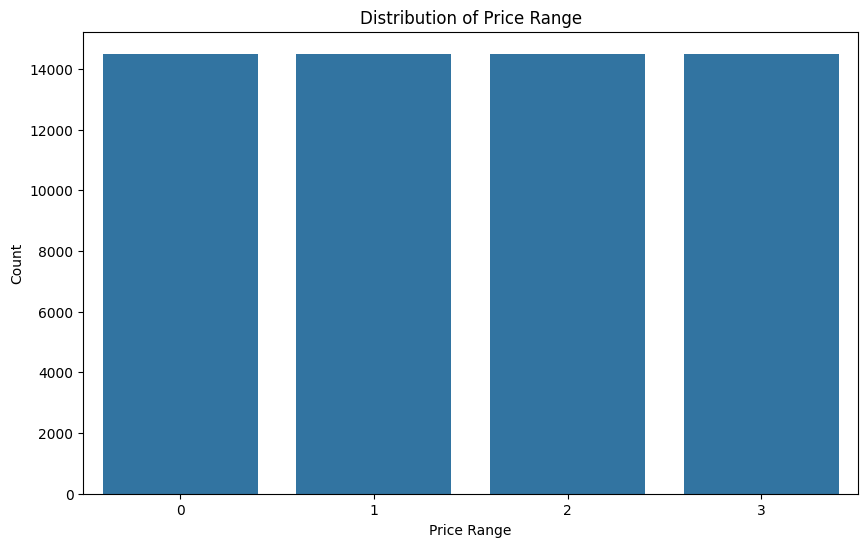

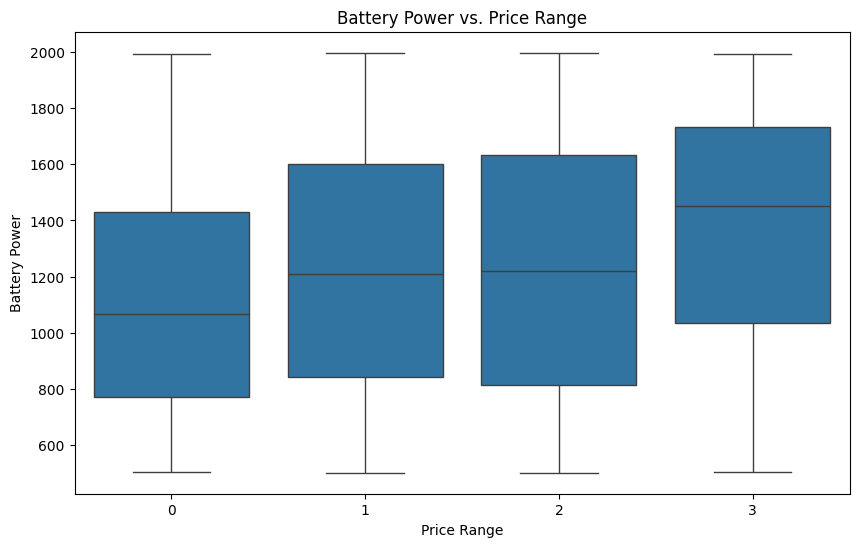

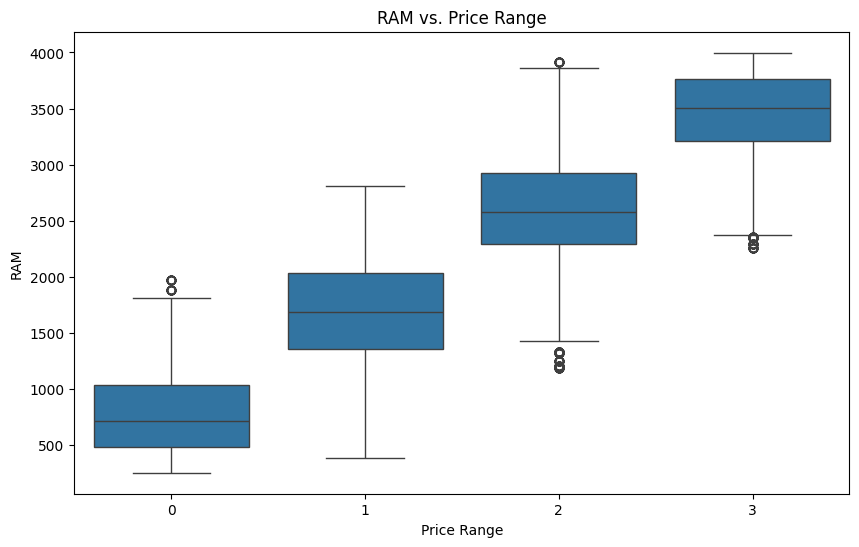

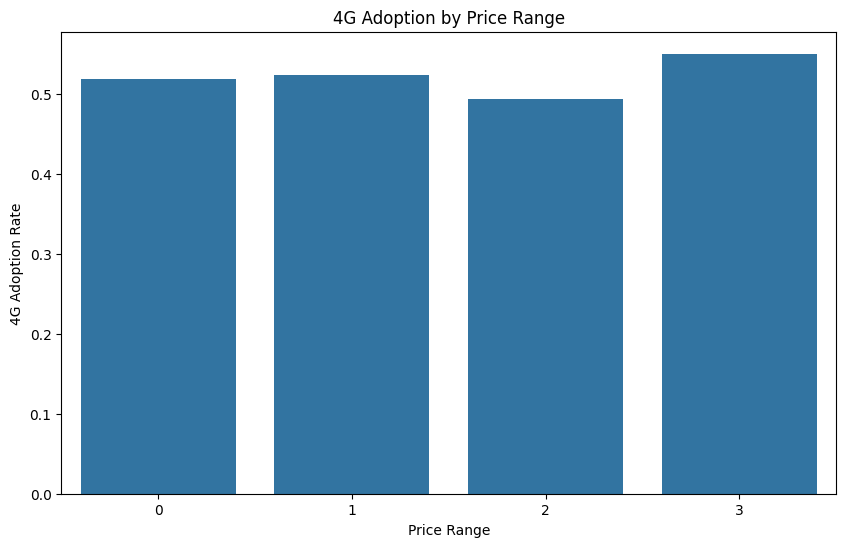

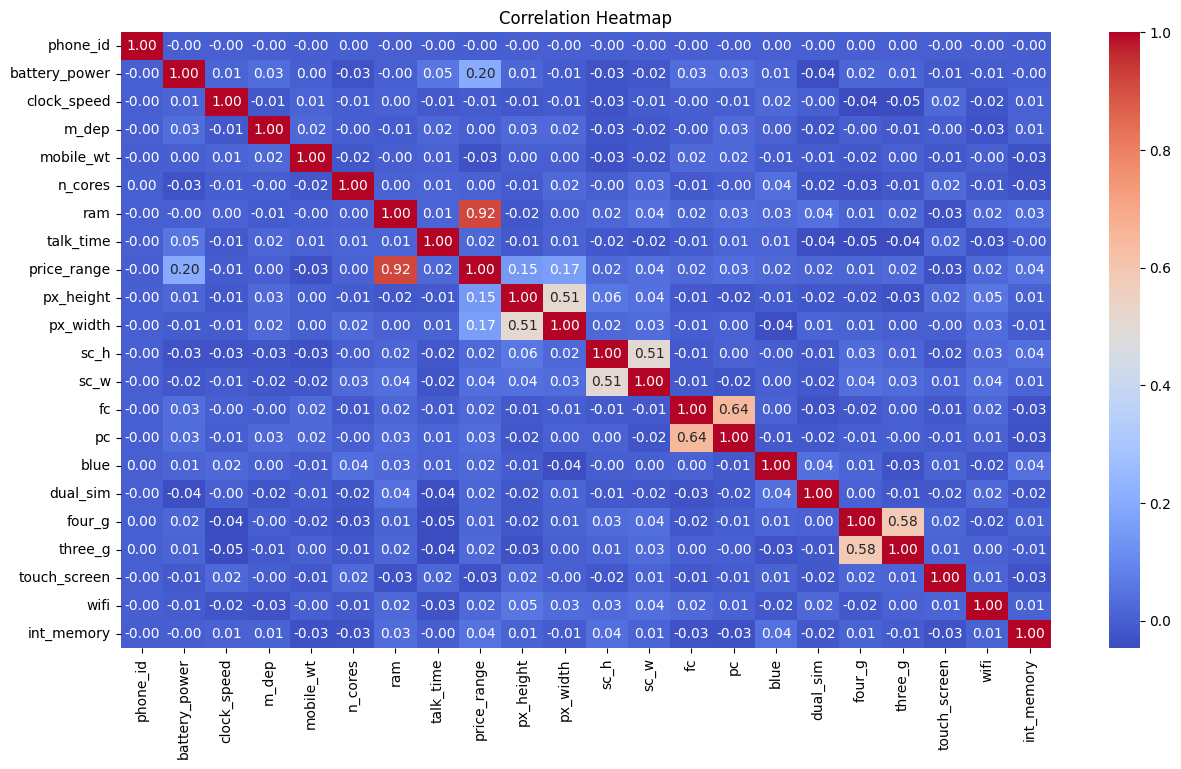

In [6]:
import seaborn as sns

import matplotlib.pyplot as plt

# 1. Distribution of Price Range
plt.figure(figsize=(10, 6))
sns.countplot(x='price_range', data=df_complete)
plt.title('Distribution of Price Range')
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.show()

# 2. Battery Power vs. Price Range
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_range', y='battery_power', data=df_complete)
plt.title('Battery Power vs. Price Range')
plt.xlabel('Price Range')
plt.ylabel('Battery Power')
plt.show()

# 3. RAM vs. Price Range
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_range', y='ram', data=df_complete)
plt.title('RAM vs. Price Range')
plt.xlabel('Price Range')
plt.ylabel('RAM')
plt.show()

# 4. 4G Adoption by Price Range
plt.figure(figsize=(10, 6))
four_g_adoption = df_complete.groupby('price_range')['four_g'].mean().reset_index()
sns.barplot(x='price_range', y='four_g', data=four_g_adoption)
plt.title('4G Adoption by Price Range')
plt.xlabel('Price Range')
plt.ylabel('4G Adoption Rate')
plt.show()

# 5. Correlation Heatmap
plt.figure(figsize=(15, 8))
correlation_matrix = df_complete.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()